## Example with CNN-LSTM on live BTC close price using the full data

In [84]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [87]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (168742, 8)


### Generate Candles and build features from technical analysis

In [88]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [89]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 10000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 10000 steps
Generated time-series
Normalized 'candles_norm' with shape : (10000, 9)
Feature data 'x_candles' with size : 9952
Feature data with time intervals 'x_time' with size : 9952


[0.3689511661044419,
 0.36786650460022857,
 0.3674846469364436,
 0.36833331057119323,
 0.3676363338386529,
 0.36843300874521434,
 0.3693421286243018,
 0.36872481938241763,
 0.36744321984130246,
 0.36547092591833863]

## Train CNN-LSTM model using full data set

In [90]:
btc_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
btc_model.sats2model()

In [95]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
SAVE_NEW_MODEL = True
PRESAVED_MODELDATE = "220615_16_31"

if SAVE_NEW_MODEL:
  model_name = f"model/LSTM_CNN_MODEL_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, epochs=20)

Epoch 1/100
3/3 [==============================] - 0s 185ms/step - loss: 0.0310 - val_loss: 0.0187
Epoch 2/100
3/3 [==============================] - 0s 170ms/step - loss: 0.0209 - val_loss: 0.0329
Epoch 3/100
3/3 [==============================] - 0s 152ms/step - loss: 0.0209 - val_loss: 0.0329
Epoch 4/100
3/3 [==============================] - 0s 109ms/step - loss: 0.0278 - val_loss: 0.0102
Epoch 5/100
3/3 [==============================] - 0s 153ms/step - loss: 0.0178 - val_loss: 0.0194
Epoch 6/100
3/3 [==============================] - 0s 107ms/step - loss: 0.0186 - val_loss: 0.0198
Epoch 7/100
3/3 [==============================] - 0s 169ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 8/100
3/3 [==============================] - 0s 155ms/step - loss: 0.0141 - val_loss: 0.0101
Epoch 9/100
3/3 [==============================] - 0s 155ms/step - loss: 0.0124 - val_loss: 0.0143
Epoch 10/100
3/3 [==============================] - 0s 168ms/step - loss: 0.0120 - val_loss: 0.0087
Epoch 11/

INFO:tensorflow:Assets written to: model/LSTM_CNN_MODEL_220615_16_31/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_MODEL_220615_16_31/assets


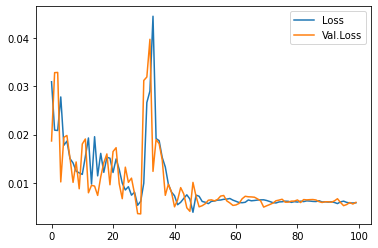

In [96]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [ ]:
btc_model.sats2train(model_name, epochs=100)

In [ ]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [97]:
btc_model.sats2pred(predict_on_test = False)
btc_model.preds

array([[0.5718382 ],
       [0.57151556],
       [0.5711942 ],
       ...,
       [0.36455828],
       [0.3648686 ],
       [0.3651091 ]], dtype=float32)

In [98]:
loaded_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.train_test_split()
loaded_model.sats2pred(predict_on_test = False)
loaded_model.preds

array([[0.5718382 ],
       [0.57151556],
       [0.5711942 ],
       ...,
       [0.36455828],
       [0.3648686 ],
       [0.3651091 ]], dtype=float32)

In [26]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(btc_model.preds)

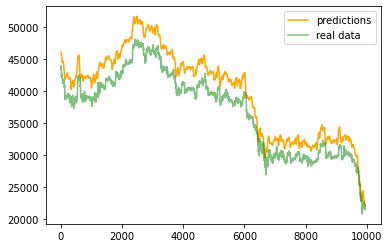

In [106]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

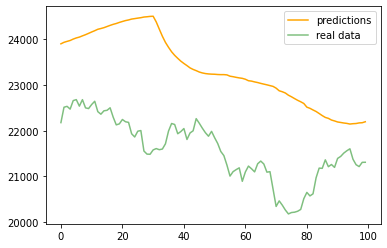

In [109]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

## Predict the last time step, so should predict following close price

In [101]:
norm_new_y = btc_model.model.predict([btc_model.x_test_candles[-1:], btc_model.x_test_time[-1:]], batch_size=btc_model.batch_size)
pred_new_y = ts_btc.denorm(norm_new_y)
last_y = ts_btc.denorm(ts_btc.candles_norm[-1:,-1:])
last_y_candle = ts_btc.candles.iloc[-1,-1]
last_y_time = ts_btc.candles.index[-1]

In [102]:
pred_new_y

[20954.181856271618]

In [103]:
last_y_candle

20993.92

In [104]:
last_y_time

Timestamp('2022-06-15 16:31:00')

## Download new data, generate features and time series

In [105]:
ldata_df_new = crypto.load_cryptos(tickers,save = False)
new_can_btc = fb.Candles(ldata_df_new,"Bitcoin")
new_can_btc.buildfeatures()
new_ts_btc = c2t.Candle2TimeSeries(new_can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

new_ts_btc.candles2ts()

All caught up..!
size of dataset: (168743, 8)
Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [41]:
last_new_y_time = new_ts_btc.candles.index[-1]
last_new_y_times = new_ts_btc.candles.index [ new_ts_btc.candles.index >= last_y_time ]
new_time_steps = len(last_new_y_times)
last_new_y_times

DatetimeIndex(['2022-06-15 15:16:00', '2022-06-15 15:31:00',
               '2022-06-15 15:46:00'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [42]:
new_ts_btc.x_candles = np.asarray(new_ts_btc.x_candles, dtype=np.float32)
new_ts_btc.x_time = np.asarray(new_ts_btc.x_time, dtype=np.float32)

norm_new_y = btc_model.model.predict([new_ts_btc.x_candles[-new_time_steps:], new_ts_btc.x_time[-new_time_steps:]], batch_size=btc_model.batch_size)
pred_new_y = ts_btc.denorm(norm_new_y)
true_last_y = ts_btc.denorm(ts_btc.candles_norm[-new_time_steps:,-1])
new_y_candles = ts_btc.candles.iloc[-new_time_steps:,-1]

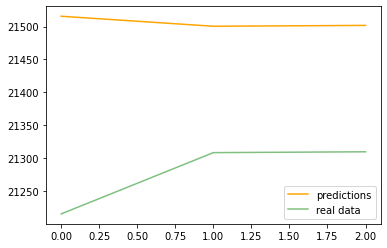

In [43]:
plt.plot(pred_new_y, color='orange', label='predictions')
plt.plot(true_last_y, color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()